# Web Scraping for Reddit & Predicting Comments

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results

In [112]:
import requests
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import time 

from bs4 import BeautifulSoup
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
request_list = [] # Empty list to store all pages of html data
id_list = [0]

for i in range(0,1000,25): # Iterate pages by skipping 25 because each pages in reddit increases by count 25
    response = requests.get("http://www.reddit.com/?count="+str(i)+"&after="+str(id_list[-1]), headers = {'User-agent': 'General Assembly DSI Project'}) # set variable response to request and scrape all data in the url that iterates by 25 and set headers to user-agent to avoid reddit blocking me
    soup = BeautifulSoup(response.content, 'lxml') # Convert variable response to text and lxml format using beautifulsoup to make it readable.
    request_list.append(soup) # Append all converted scraped html data to empty list called request_list
    id_list.append(soup.find_all('div', attrs={'data-type': 'link'})[-1]['data-fullname'])
    if i%500 == 0: # if each iteration can be divided by 500 have no remainder,
        time.sleep(120) # put computer to sleep by 60 seconds to avoid reddit blocking me 

### Write 4 functions to extract these items (one function for each): title, time, subreddit, and number of comments.

In [ ]:
# This function extracts only title from request_list
def extract_title(request_list):    
    title = [] # Empty list to store title in   
    for i in request_list: # Iterate through request_list
        if response.status_code == 200: # if response status code is 200 then run the for loop below
            for each in i.find_all('p', attrs={'class': 'title'}): # Find all attribute class: title in p tag to extract title only 
                title.append(each.text) # append the title thats in text format to title list
        else:
            print("Call failed at request ", i) # if status code is not 200 print this for each iteration that fails           
    return title # return the output in the list

fetch_titles = extract_title(request_list) # set the function as a variable called fetch_title
print(fetch_titles)

In [ ]:
# Same process that only extracts time in request_list
def extract_time(request_list):
    time = []
    for i in request_list:
        if response.status_code == 200:
            for each in i.find_all('time', attrs={'class': 'live-timestamp'}):
                time.append(each['title'])
        else:
            print("Call failed at request ", i)    
    return time

fetch_time = extract_time(request_list)
print(fetch_time)

In [ ]:
# Same process but extracting only subreddit in request_list
def extract_subreddit(request_list):
    subreddit = []
    for i in request_list:
        if response.status_code == 200:
            for each in i.find_all('a', attrs={'class': 'subreddit'}):
                subreddit.append(each.text)
        else:
            print("Call failed at request ", i)    
    return subreddit

fetch_subreddit = extract_subreddit(request_list)
print(fetch_subreddit)

In [ ]:
# Same process that extracts only number of comments in request list
def extract_number_of_comments(request_list):
    number_of_comments = []
    for i in request_list:
        if response.status_code == 200:
            for each in i.find_all('a', attrs={'class': 'bylink comments may-blank'}):
                number_of_comments.append(each.text.split()[0])
        else:
            print("Call failed at request ", i)    
    return number_of_comments

fetch_number_of_comments = extract_number_of_comments(request_list)
print(fetch_number_of_comments)

In [ ]:
print('Length of Title:', len(fetch_titles))
print('Length of Time', len(fetch_time))
print('Length of Subreddit', len(fetch_subreddit))
print('Length of Number of Comments', len(fetch_number_of_comments))

### Write one more function that finds the last `id` on the page, and stores it.

In [ ]:
# In converted html data, find all attributes that have 
# data-type:link inside the div, look for last data-fullname
def last_id(soup):
    all_div = soup.find_all('div', attrs={'data-type': 'link'})
    return all_div[-1]['data-fullname']

last_id(soup)

### Putting it all together into a DataFrame.

In [ ]:
# Putting all fetched variables, giving a title and make dataframe.
df = pd.DataFrame({'title':fetch_titles,
                   'time': fetch_time, 
                   'subreddit': fetch_subreddit, 
                   'number_of_comments':fetch_number_of_comments})

### Save results as a CSV

In [ ]:
# Export to csv
df.to_csv('reddit_web_scraping.csv', index=False)

# --------------------------EDA----------------------------------

#### Load in the the data of scraped results

In [141]:
# Read web scrapped file as df
df = pd.read_csv('./reddit_web_scraping.csv')

In [142]:
# Read top 5 rows of df
df.head()

,number_of_comments,subreddit,time,title
0,570,r/aww,Wed Feb 21 19:50:46 2018 UTC,Found this guy under my car this morning. Spen...
1,448,r/funny,Wed Feb 21 19:55:10 2018 UTC,When the student refuses to cooperate (r/Legit...
2,146,r/oddlysatisfying,Wed Feb 21 20:14:16 2018 UTC,Heavy rain leaves trail under crystalline wate...
3,640,r/history,Wed Feb 21 19:36:14 2018 UTC,"New ""Discovery Mode"" turns video game ""Assassi..."
4,633,r/web_design,Wed Feb 21 17:43:34 2018 UTC,Animated login avatar<form> (v.redd.it)


#### Predict a binary variable - whether the number of comments was low or high.

In [143]:
# 401 is the cut off for high or low number of comments.
df['number_of_comments'].describe()

count    1000.000000
mean      438.536000
std       962.326127
min         1.000000
25%        52.000000
50%       135.500000
75%       401.000000
max      8817.000000
Name: number_of_comments, dtype: float64

In [144]:
# Converting comments that are higher than 652 as 1  else 0 in high_comments column.
df['high_comments'] = df['number_of_comments'].map(lambda x: 1 if x > 401.00 else 0)

In [145]:
df.head()

,number_of_comments,subreddit,time,title,high_comments
0,570,r/aww,Wed Feb 21 19:50:46 2018 UTC,Found this guy under my car this morning. Spen...,1
1,448,r/funny,Wed Feb 21 19:55:10 2018 UTC,When the student refuses to cooperate (r/Legit...,1
2,146,r/oddlysatisfying,Wed Feb 21 20:14:16 2018 UTC,Heavy rain leaves trail under crystalline wate...,0
3,640,r/history,Wed Feb 21 19:36:14 2018 UTC,"New ""Discovery Mode"" turns video game ""Assassi...",1
4,633,r/web_design,Wed Feb 21 17:43:34 2018 UTC,Animated login avatar<form> (v.redd.it),1


#### What is the baseline accuracy?

In [146]:
# Baseline accuracy for high comments
baseline = 1-(df['high_comments'].mean())
print('Baseline Accuracy:', baseline)

Baseline Accuracy: 0.752


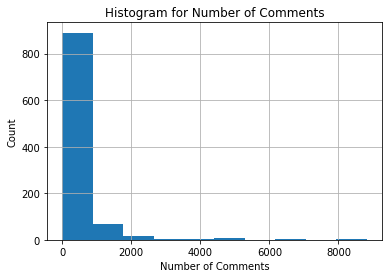

In [227]:
# Plot a histogram to see the distribution for number of comments.
df['number_of_comments'].hist()
plt.title('Histogram for Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Count');

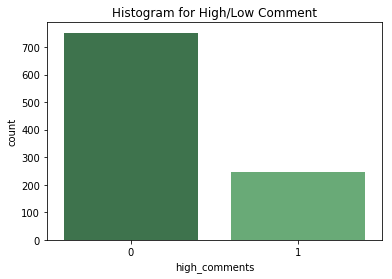

In [148]:
# Plot a bargraph to compare high comments (1) vs low comments (0).
ax = plt.axes()
sns.countplot(x="high_comments", data=df, palette="Greens_d")
ax.set_title('Histogram for High/Low Comment')
plt.show();

To predict the number of comments, data needs to be converted into a binary classification problem by splitting the "number_of_comments" column into two classes, high or low number of comments to 1 or 0 (binary). 

Since the mean for the "number_of_comments" is 438, data were split on the 75th percentile which is 401 comments as a breaking point. After deciding the breaking point for the high comments, the "number_of_comments" data has been filtered out by assigning comments that are higher than 401 as 1 else 0 and stored the result into a new column called "high_comments".

After the feature engineering, histograms show that the data is heavily skewed positively which indicates that the mean is less than the median and the mode. This explains that there are more 0 than 1, more low comments than high comments. In addition, a baseline accuracy was calculated by getting the average of the "high_comments" column and subtract 1 from it. The main reason to subtract 1 is that there are more low comments than high comments. The average result for high comments (1) is showing 25% accuracy whereas low comments(0) is 75% accuracy in predicting the Y-value. Therefore, it makes perfect sense to choose higher accuracy even though this is a very simple baseline accuracy.

A baseline is a method that uses a very simple summary statistic to predict a dataset by getting the average. This baseline accuracy result will be used to compare with other models to determine the performance of other machine learning models.

In [229]:
# Import Counter from collections library to count most occurring words.
from collections import Counter

# Write a function to extract the most common words in title.
split_list = [] # Empty list to store each words.
for each in df['title']: # Iterate through each title in title column.
    for word in each.split(): # Split title into each words.
        split_list.append(word) # Append each words into empty list split_list.
    
count_words = Counter(split_list) # Counts how many times each word shows up.
counts_df = pd.DataFrame.from_dict(count_words, orient='index')\
.reset_index().sort_values(0, ascending=False) # Sort highest number of counts to lowest.

In [230]:
counts_df.head(10)

,index,0
16,(i.redd.it),426
18,the,333
46,a,304
21,to,243
110,(i.imgur.com),229
127,in,180
55,of,166
14,and,138
344,I,113
75,for,95


In [234]:
# Write a function to extract the most common subreddit in subreddit.
from collections import Counter

split_list = []
for each in df['subreddit']:
    for word in each.split():
        split_list.append(word)
    
count_subred = Counter(split_list)
counts_df2 = pd.DataFrame.from_dict(count_subred, orient='index')\
.reset_index().sort_values(0, ascending=False)

In [235]:
counts_df2.head(10)

,index,0
0,r/aww,29
1,r/funny,28
28,r/BlackPeopleTwitter,25
8,r/todayilearned,22
9,r/gifs,21
46,r/gaming,20
24,r/pics,18
77,r/interestingasfuck,15
111,r/FortNiteBR,12
82,r/AskReddit,12


Before getting into modeling part to predict the high number of comments, functions above extracts the top 10 most occurring words in titles and top 10 subreddit sentences in subreddits to approximately see what words or sentences could drive the higher number of comments. Based on the result, it can roughly show what type of models to use to predict the target, the high number of comments. 

For example, since words in title contains many meaningless data such as "the, a, to, in, of, and, I, for, etc.", this can be filtered out by using the Count Vectorizer method by setting the stop words as English which will filter out meaningless words to return only meaningful words. 

On the other hands, subreddits field cannot use Count Vectorizer method since it is a one chunk sentence and it cannot be broken down into pieces using Count Vectorizer method. Therefore, other modeling technique must be used.

# --------------------------Data Modeling----------------------------------

## Predicting high comments using Random Forests + Another Classifier

## Random Forest Model 1

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [240]:
# Define X and y
X = pd.get_dummies(df['subreddit'])
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Random Forest Classifier model
# Fit X_train and y_train to predict
rand_forest1 = RandomForestClassifier()
rand_forest1.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = rand_forest1.score(X_test, y_test)
cvs = cross_val_score(rand_forest1, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('1st Random Forest Model Score with Subreddit:', score)
print('1st Random Forest 5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
1st Random Forest Model Score with Subreddit: 0.838
1st Random Forest 5 Folds Cross-Validation Score: 0.836


The first random forest model score result using only subreddit as a feature to predict the high number of comments show that it is approximately 86% correct in predicting high comments (target) just using subreddits (feature). 

In addition, the 5 folds cross-validation score result show that the random forest model is approximately 82% correct in predicting the high comments. The cross-validation method reduces overfitting (variance) by splitting the training sets into 5 different sets to predict the y-value (high comments) which will deliver more accurate result. 

Based on this result, this model performs better than the baseline by 11% better on random forest model alone, 7% better with 5 folds cross-validation.

In [241]:
# Function that calculates and show confusion matrix.
def conf_mat(y_test, preds): # Define a function that takes y_test and preds as arguments.
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # This splits the confusion matrix as true negative, false positive, false negative, and true positive. 
    print('Confusion Matrix:\n', confusion_matrix(y_test, preds)) # This shows confusion matrix chart.
    print('Accuracy:', (tp + tn)/(tp+fn+fp+tn)) # Formula for accuracy.
    print('Misclassification:', 1 - ((tp + tn)/(tp+fn+fp+tn))) # Formula for misclassification.
    print('Sensitivity', tp/(tp + fn)) # Formula for sensitivity.
    print('specificity', tn/(tn+fp)) # Formula for specificity.
    print('precision', tp/(tp+fp)) # Formula for precision.

In [242]:
rand_forest1_preds = rand_forest1.predict(X_test) # Predicts y-value using the first random forest model using x-test set.
conf_mat(y_test, rand_forest1_preds) # Show confusion matrix and calculate all the formulas in the function.

Confusion Matrix:
 [[353  12]
 [ 69  66]]
Accuracy: 0.838
Misclassification: 0.162
Sensitivity 0.488888888889
specificity 0.967123287671
precision 0.846153846154


The confusion matrix for the first random forest model shows...

- **Accuracy:** In overall, 81% correct on predicting high comments.

- **Misclassification:** In overall, it is 18% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 45% out of all true high comments.

- **Specificity:** It correctly identified low comments 94% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 73% out of all threads that the model predicts are the high comments.

## Random Forest Model 2

In [243]:
# Feature engineering new columns
df['cat_in_title'] = [1 if 'cat' in each.lower() else 0 for each in df['title']]
df['funny_in_title'] = [1 if 'funny' in each.lower() else 0 for each in df['title']]
df['musk_in_title'] = [1 if 'musk' in each.lower() else 0 for each in df['title']]
df['trump_in_title'] = [1 if 'trump' in each.lower() else 0 for each in df['title']]

In [244]:
df.head()

,number_of_comments,subreddit,time,title,high_comments,cat_in_title,funny_in_title,musk_in_title,trump_in_title
0,570,r/aww,Wed Feb 21 19:50:46 2018 UTC,Found this guy under my car this morning. Spen...,1,0,0,0,0
1,448,r/funny,Wed Feb 21 19:55:10 2018 UTC,When the student refuses to cooperate (r/Legit...,1,1,0,0,0
2,146,r/oddlysatisfying,Wed Feb 21 20:14:16 2018 UTC,Heavy rain leaves trail under crystalline wate...,0,0,0,0,0
3,640,r/history,Wed Feb 21 19:36:14 2018 UTC,"New ""Discovery Mode"" turns video game ""Assassi...",1,0,0,0,0
4,633,r/web_design,Wed Feb 21 17:43:34 2018 UTC,Animated login avatar<form> (v.redd.it),1,0,0,0,0


In [245]:
# Define X and y
X = df[['cat_in_title', 'funny_in_title', 'musk_in_title', 'trump_in_title']]
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Random Forest Classifier model
# Fit X_train and y_train to predict
rand_forest2 = RandomForestClassifier()
rand_forest2.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = rand_forest2.score(X_test, y_test)
cvs = cross_val_score(rand_forest2, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('2nd Random Forest Model Score with Words in Title:', score)
print('2nd Random Forest 5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
2nd Random Forest Model Score with Words in Title: 0.764
2nd Random Forest 5 Folds Cross-Validation Score: 0.75999039904


In [246]:
print("Value Counts for Word Cat:\n", df['cat_in_title'].value_counts())
print("Value Counts for Word Funny:\n", df['funny_in_title'].value_counts())
print("Value Counts for Word Musk:\n", df['musk_in_title'].value_counts())
print("Value Counts for Word Trump:\n", df['trump_in_title'].value_counts())

Value Counts for Word Cat:
 0    910
1     90
Name: cat_in_title, dtype: int64
Value Counts for Word Funny:
 0    994
1      6
Name: funny_in_title, dtype: int64
Value Counts for Word Musk:
 0    993
1      7
Name: musk_in_title, dtype: int64
Value Counts for Word Trump:
 0    996
1      4
Name: trump_in_title, dtype: int64


In [247]:
rand_forest2_preds = rand_forest2.predict(X_test)
conf_mat(y_test, rand_forest2_preds)

Confusion Matrix:
 [[377   2]
 [116   5]]
Accuracy: 0.764
Misclassification: 0.236
Sensitivity 0.0413223140496
specificity 0.994722955145
precision 0.714285714286


I have performed feature engineering by creating 4 new columns to extract words cat, funny, musk, and trump in the title to see if these 4 words have any effects on predicting high comments. 

The model score result shows that these words do not bring any values in predicting the high comments since it performs where the baseline accuracy is (75%).  


In addition, value counts for these 4 words show that these 4 words do not appear often in the title to generate enough data to make an impact on the model or maybe these 4 words do not have any relationship in predicting the high comments. 

Due to my personal curiosity, I will feature engineer two more columns to see if the length of title and the post that was posted in the noon or morning can affect in predicting the high number of comments.

The confusion matrix for the second random forest model shows...

- **Accuracy:** In overall, 77% correct on predicting high comments.

- **Misclassification:** In overall, it is 23% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 3% out of all true high comments.

- **Specificity:** It correctly identified low comments 99% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 80% out of all threads that the model predicts are the high comments.

## Random Forest Model 3

In [248]:
# Set column title to a variable called title to pass through the function.
title = df['title']

def avg_title_length(title): # Define a function that takes in title as argument.
    title_length = [] # Empty list to append title length.
    for i in title: # Iterate through title that I've set up earlier to extract titles.
        title_length.append(len(i)) # Get length of each title in fetch_title.
    return title_length 

In [249]:
# Set funtion that have length of title as a variable list_of_lengths.
list_of_lengths = avg_title_length(title)

# Caculate average length of title and average is 70.11
average_length = sum(list_of_lengths)/len(list_of_lengths)
print('Average Length for Title:', average_length)

Average Length for Title: 70.406


In [250]:
# Feature engineer new column title_length that stores all length of title
df['title_length'] = avg_title_length(title)

# Create another column title_length_avg that converts any 
# title length that are higher than average into 1 else 0.
df['title_length_avg'] = df['title_length'].map(lambda x: 1 if x > average_length else 0)

In [251]:
# Feature engineer time to set 1 if time is greater than 12 else 0
df['afternoon/morning_time'] = [1 if i[11:13] > '12' else 0 for i in df['time']]

In [252]:
df.head()

,number_of_comments,subreddit,time,title,high_comments,cat_in_title,funny_in_title,musk_in_title,trump_in_title,title_length,title_length_avg,afternoon/morning_time
0,570,r/aww,Wed Feb 21 19:50:46 2018 UTC,Found this guy under my car this morning. Spen...,1,0,0,0,0,114,1,1
1,448,r/funny,Wed Feb 21 19:55:10 2018 UTC,When the student refuses to cooperate (r/Legit...,1,1,0,0,0,71,1,1
2,146,r/oddlysatisfying,Wed Feb 21 20:14:16 2018 UTC,Heavy rain leaves trail under crystalline wate...,0,0,0,0,0,96,1,1
3,640,r/history,Wed Feb 21 19:36:14 2018 UTC,"New ""Discovery Mode"" turns video game ""Assassi...",1,0,0,0,0,184,1,1
4,633,r/web_design,Wed Feb 21 17:43:34 2018 UTC,Animated login avatar<form> (v.redd.it),1,0,0,0,0,39,0,1


In [253]:
# Define X and y
X = df[['title_length_avg', 'afternoon/morning_time']]
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Random Forest Classifier model
# Fit X_train and y_train to predict
rand_forest3 = RandomForestClassifier()
rand_forest3.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = rand_forest3.score(X_test, y_test)
cvs = cross_val_score(rand_forest3, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('3rd Random Forest Model Score\nwith Title Length and Afternoon/Morning Time:', score)
print('3rd Random Forest 5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
3rd Random Forest Model Score
with Title Length and Afternoon/Morning Time: 0.766
3rd Random Forest 5 Folds Cross-Validation Score: 0.758


In [254]:
rand_forest3_preds = rand_forest3.predict(X_test)
conf_mat(y_test, rand_forest3_preds)

Confusion Matrix:
 [[363  17]
 [100  20]]
Accuracy: 0.766
Misclassification: 0.234
Sensitivity 0.166666666667
specificity 0.955263157895
precision 0.540540540541


3rd random forest model that uses title length and afternoon and morning time as features perform approximately where the baseline accuracy is (75%). Therefore, this model is also not a good model for predicting the high number of comments. 

The confusion matrix for the 3rd random forest model shows...

- **Accuracy:** In overall, 75% correct on predicting high comments.

- **Misclassification:** In overall, it is 25% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 14% out of all true high comments.

- **Specificity:** It correctly identified low comments 95% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 50% out of all threads that the model predicts are the high comments.

#### Repeat the model-building process with a non-tree-based method.

## Logistic Regression Model 1

In [255]:
# Define X and y
X = pd.get_dummies(df['subreddit'])
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Logistic Regression model
# Fit X_train and y_train to predict
logreg1 = LogisticRegression()
logreg1.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = logreg1.score(X_test, y_test)
cvs = cross_val_score(logreg1, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('1st Logistic Regression Model Score with Subreddit Feature:', score)
print('1st Logistic Regression 5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
1st Logistic Regression Model Score with Subreddit Feature: 0.786
1st Logistic Regression 5 Folds Cross-Validation Score: 0.7619609961


Using Logistic Regression and subreddit as a feature, this model performs approximately 78% accurate on predicting the high number of comments and 78% with 5 folds cross-validation score. This model performs slightly better than the baseline accuracy by approximately 3%.

In [256]:
logreg1_preds = logreg1.predict(X_test)
conf_mat(y_test, logreg1_preds)

Confusion Matrix:
 [[377   1]
 [106  16]]
Accuracy: 0.786
Misclassification: 0.214
Sensitivity 0.131147540984
specificity 0.997354497354
precision 0.941176470588


The confusion matrix for the first logistic regression model shows...

- **Accuracy:** In overall, 79% correct on predicting high comments.

- **Misclassification:** In overall, it is 21% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 11% out of all true high comments.

- **Specificity:** It correctly identified low comments 100% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 100% out of all threads that the model predicts are the high comments.

## Logistic Regression Model 2

In [257]:
# Define X and y
X = df[['cat_in_title', 'funny_in_title', 'musk_in_title', 'trump_in_title']]
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Logistic Regression model
# Fit X_train and y_train to predict
logreg2 = LogisticRegression()
logreg2.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = logreg2.score(X_test, y_test)
cvs = cross_val_score(logreg2, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('Logistic Regression Model Score:', score)
print('5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
Logistic Regression Model Score: 0.772
5 Folds Cross-Validation Score: 0.77


In [258]:
logreg2_preds = logreg2.predict(X_test)
conf_mat(y_test, logreg2_preds)

Confusion Matrix:
 [[385   0]
 [114   1]]
Accuracy: 0.772
Misclassification: 0.228
Sensitivity 0.00869565217391
specificity 1.0
precision 1.0


The confusion matrix for the 2nd logistic regression model shows...

- **Accuracy:** In overall, 76% correct on predicting high comments.

- **Misclassification:** In overall, it is 24% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 2% out of all true high comments.

- **Specificity:** It correctly identified low comments 100% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 100% out of all threads that the model predicts are the high comments.

## Logistic Regression Model 3

In [259]:
# Define X and y
X = df[['title_length_avg', 'afternoon/morning_time']]
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Use Logistic Regression model
# Fit X_train and y_train to predict
logreg3 = LogisticRegression()
logreg3.fit(X_train, y_train)

# Predict score result using X_test and y_test 
# Use Cross Validation Score to check how accurate the model is
score = logreg3.score(X_test, y_test)
cvs = cross_val_score(logreg3, X_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('Logistic Regression Model Score:', score)
print('5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
Logistic Regression Model Score: 0.742
5 Folds Cross-Validation Score: 0.742149214921


Using Logistic Regression, words cat, funny, musk, and trump as features for the 2nd model and title length and afternoon/morning time as features for the 3rd model, both models perform where the baseline is 75%.
Therefore, I can conclude that these features do not add any values for predicting the high number of comments.

In [260]:
logreg3_preds = logreg3.predict(X_test)
conf_mat(y_test, logreg3_preds)

Confusion Matrix:
 [[351  15]
 [114  20]]
Accuracy: 0.742
Misclassification: 0.258
Sensitivity 0.149253731343
specificity 0.959016393443
precision 0.571428571429


The confusion matrix for the 3rd logistic regression model shows...

- **Accuracy:** In overall, 74% correct on predicting high comments.

- **Misclassification:** In overall, it is 25% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 14% out of all true high comments.

- **Specificity:** It correctly identified low comments 96% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 57% out of all threads that the model predicts are the high comments.

## Grid Search on Logistic Regression Model 1

In [261]:
# Set X and y
X = pd.get_dummies(df['subreddit'])
y = df['high_comments']

# Split X and y in half into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Set param_grid
# method for penalty l1 = Lasso, l2 = Ridge
# C is setting severity for penalty  
params_grid = {'penalty': ['l1', 'l2'],'C': [.001, .1, 1.0, 10.0]}

# Run Gridsearch using logreg1 model with 5 folds cross-validation
gs = GridSearchCV(logreg1, params_grid, verbose=1, cv=5)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [262]:
best_logreg = gs.best_estimator_
best_score = best_logreg.score(X_test, y_test)
cvs = cross_val_score(best_logreg, X_test, y_test, cv=5).mean()

print('Best Logistic Regression Estimator:\n\t', best_logreg)
print('Logistic Regression Best Score:', best_score)
print('5 folds Cross-Validation Score:', cvs)

Best Logistic Regression Estimator:
	 LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression Best Score: 0.856
5 folds Cross-Validation Score: 0.824


Using grid search model, this model tests multiple scores and picks out the best score to use. Since the feature subreddit performed the best to predict the high comments compared to other features, using grid search model with logistic regression will optimize the model and increase the accuracy of predicting the high comments.

The result for optimized logistic regression shows that the score is approximately 86% correct on predicting high comments and with cross-validation score, it is approximately 83% correct in predicting the high comments. This model performs 11% better on itself and 8% better after 5 folds cross-validation.

In [263]:
gs_preds = best_logreg.predict(X_test)
conf_mat(y_test, gs_preds)

Confusion Matrix:
 [[361   9]
 [ 63  67]]
Accuracy: 0.856
Misclassification: 0.144
Sensitivity 0.515384615385
specificity 0.975675675676
precision 0.881578947368


The confusion matrix for the grid search for 1st logistic regression model shows...

- **Accuracy:** In overall, 86% correct on predicting high comments.

- **Misclassification:** In overall, it is 14% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 52% out of all true high comments.

- **Specificity:** It correctly identified low comments 98% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 88% out of all threads that the model predicts are the high comments.

In [210]:
temp_df = pd.DataFrame()

In [211]:
temp_df['subreddits'] = X_train.columns
temp_df['count'] = X_train.sum().values
temp_df['coef'] = best_logreg.coef_[0]

In [212]:
temp_df2 = temp_df.sort_values('count', ascending=False).head(10)
temp_df2.head(10)

,subreddits,count,coef
24,r/BlackPeopleTwitter,18,3.172901
189,r/funny,15,3.167854
197,r/gifs,14,3.862581
145,r/aww,12,3.160267
193,r/gaming,11,-0.800193
278,r/todayilearned,9,3.147678
246,r/pics,9,4.069403
295,r/worldnews,7,2.903768
215,r/interestingasfuck,7,2.903768
13,r/AskReddit,6,7.968692


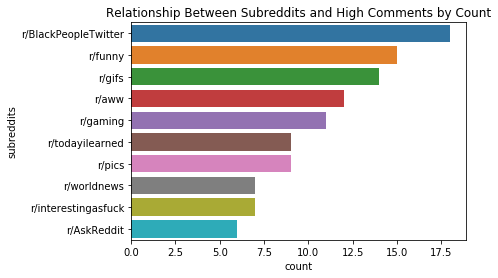

In [221]:
ax = plt.axes()
sns.barplot(x="count", y="subreddits", data=temp_df2)
ax.set_title('Relationship Between Subreddits and High Comments by Count')
plt.show();

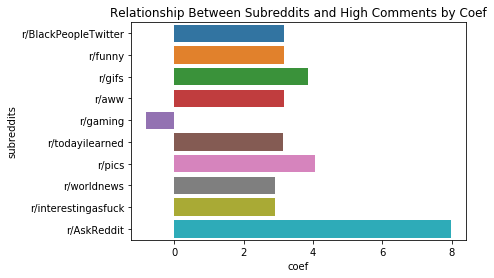

In [222]:
ax = plt.axes()
sns.barplot(x="coef", y="subreddits", data=temp_df2)
ax.set_title('Relationship Between Subreddits and High Comments by Coef')
plt.show();

The first bar graph shows the relationship between the top 10 subreddit and high comments by count. It is organized by the highest count to lowest meaning how many times it shows up in the subreddit. 

On the other hand, the second graph shows the actual relationship between the top 10 subreddit and the high comments by the coefficient. In this graph, it shows that the highest count subreddit does not have a high coefficient or relationship with the high comments. For example, "r/AskReddit" only appeared 6 times but have the highest coefficient 8.

## Count Vectorizer Random Forest Model 1

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 

In [33]:
## YOUR CODE HERE
X = df['title']
y = df['high_comments']

X_train, X_test, y_train, y_test = train_test_split(X,y)

cv = CountVectorizer(stop_words='english')
cv.fit(X_train)

Xs_train = pd.DataFrame(cv.transform(X_train).todense(), columns=cv.get_feature_names())
Xs_test = pd.DataFrame(cv.transform(X_test).todense(), columns=cv.get_feature_names())

cv_rand_forest = RandomForestClassifier()
cv_rand_forest.fit(Xs_train, y_train)
score = cv_rand_forest.score(Xs_test, y_test)
cvs = cross_val_score(cv_rand_forest, Xs_test, y_test, cv=5).mean()

print('Baseline Accuracy:', baseline)
print('Second Random Forest Model Score:', score)
print('5 Folds Cross-Validation Score:', cvs)

Baseline Accuracy: 0.752
Second Random Forest Model Score: 0.928
5 Folds Cross-Validation Score: 0.808180872349


Using Count Vectorizer, Random Forest and title for a feature, model alone perform approximately 95% accurate on predicting high comments. After the 5 folds cross-validation, the model performance drops to approximately 84% accuracy. 

The model before the cross-validation performs better than the baseline accuracy by 20%. After the cross-validation, the model performs 9% better than the baseline accuracy.

In [34]:
cvs_rand_preds = cv_rand_forest.predict(Xs_test)
conf_mat(y_test, cvs_rand_preds)

Confusion Matrix:
 [[176   2]
 [ 16  56]]
Accuracy: 0.928
Misclassification: 0.072
Sensitivity 0.777777777778
specificity 0.988764044944
precision 0.965517241379


The confusion matrix for the count vectorizer with random forest model shows...

- **Accuracy:** In overall, 93% correct on predicting high comments.

- **Misclassification:** In overall, it is 7% wrong on predicting high comments.

- **Sensitivity:** It correctly identified high comments 78% out of all true high comments.

- **Specificity:** It correctly identified low comments 99% out of all true low comments.

- **Precision:** It correctly identified the number of high comments 97% out of all threads that the model predicts are the high comments.

# Executive Summary

**Executive Summary | What Drives High Number of Comments on Reddit?**

By Jin Park 2/26/2018

**Abstract:** 

This analysis sought to understand what type of features in Reddit post that will get the most engagement from the Reddit users. First, the analyst gathered all necessary data by web scraping the website Reddit.com. Additionally, the analyst looked at which features could bring the most engagement from the Reddit users by extracting four interesting words in the title, subreddits, time when the post was posted, and title length on average. The models showed that the best feature to use to determine the most engagement was subreddits. On the other hand, using other features only performed where the baseline result was 75%. Overall, models are more accurate on predicting the low comments than the high comments.

**Introduction:**

The analyst pulled all the necessary data from Reddit.com, an American social news aggregation, web content rating, and discussion online website. To pull the data, a web scraper was built using Python and BeautifulSoup library. The web scraper pulled over 40 pages that contain every 1000 results on subreddits, times, number of comments, and titles. Please note that size of this dataset is very small compared to other industrial datasets due to lack of computational power to web scrape more data. With the pulled dataset, an analysis was performed by using many different models such as Random Forest, Logistic Regression, Confusion Matrix, Grid-Search, Cross-Validation, and Count Vectorizer to predict what features determine the high comments from the Reddit users.

**Methods:**

All the features in the datasets are converted into binary classification problem into 1 or 0. Also, the target or the high number of comments was set by using the 75th percentile for the number of comments as a breaking point. Any comments that are higher than 401 comments were converted into 1 and anything below as 0. In addition, subreddits were converted into binary classification by converting into dummy variables. Also, four words were randomly selected by the analyst that analyst believes that it can impact on predicting the high number of comments. Moreover, time feature was also converted into a binary classification by converting all the post that was posted after 12:00 pm into 1 and others to 0. Lastly, the average length of the title feature was also converted into a binary by calculating the average length for the title, 70 characters. Any titles that were longer than 70 was converted into 1 and else 0.
The analysts used Random Forest Model, Logistic Regression, Confusion Matrix and Count Vectorizer to model then used Grid Search and Cross Validation to reduce variance to optimize the models result. The models analyzed how the selected 4 words in title, subreddits, time posted in the noon or morning, and length of the titles on average could affect the high number of comments. 

**Results:**

The Random Forest model that uses subreddit as a feature with 5 folds Cross-Validation performed the best out of all models for predicting the high number of comments. However, using Count Vectorizer and Random Forest model, using the title as a feature performed the best on predicting the high number of comments without performing the Cross-Validation. This may indicate that the model could be overfitted since it did not use any model optimization method to reduce variance. The features using 4 selected words, the time when the post was posted in the noon or morning, and title length on average performed only where the baseline was which is 75%. This indicates that these features do not generate any values for predicting the high number of comments since it cannot outperform the baseline accuracy. This could be due to four randomly selected words did not show up often in titles to bring any impact on the prediction. Also, time and title length do not have any relationship to predicting the high number of comments. Lastly, based on the confusion matrix results, models are better at predicting the low number of comments then the high number of comments. For example, overall models specificity score shows close to 100%.

**Recommendations:**

Since the dataset was too small, to avoid this problem, run web scraper each day or every other day for few weeks or months to gather enough data.  When gathering data, save each result into a csv or txt file and aggregate all gathered csv files into one file to increase the size of the data. By increasing the dataset, this will automatically increase accuracy in predicting the target value. Based on the models result, features that did not perform well on predicting the high number of comments can be used to predict low number of comments. Use this features to determine what drives the low number of comments to understand what could effect the high number of comments. 
